In [1]:
import numpy as np  
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')


In [2]:
Dataset = pd.read_csv('Dataset.csv')


In [3]:
Dataset['Date'] = pd.to_datetime(Dataset.Date, format="%d-%m-%Y")


In [4]:
Data_Room = Dataset[['Date', 'Room Amount']]
Data_Room = Data_Room.set_index('Date')
Data_Room.head()


,Room Amount
Date,
2013-09-01,0.0
2013-09-02,0.0
2013-09-03,0.0
2013-09-04,0.0
2013-09-05,0.0


In [5]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
           'dayofyear', 'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X


In [6]:
split_date_r = '01-Jan-2019'
Data_Room_Train = Data_Room.loc[Data_Room.index <= split_date_r].copy()
Data_Room_Test = Data_Room.loc[Data_Room.index > split_date_r].copy()


In [7]:
X_Train_R, Y_Train_R = create_features(Data_Room_Train, label='Room Amount')
X_Test_R, Y_Test_R = create_features(Data_Room_Test, label='Room Amount')


<ipython-input-5-7d898388bd09>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [8]:
XGB_R = xgb.XGBRegressor(n_estimators=1000)
XGB_R.fit(X_Train_R, Y_Train_R,
        eval_set=[(X_Train_R, Y_Train_R), (X_Test_R, Y_Test_R)],
        early_stopping_rounds=50,
        verbose=False)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

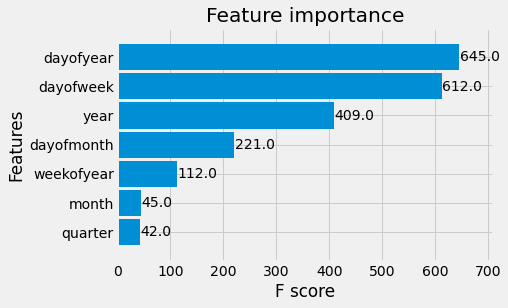

In [9]:
plot_importance(XGB_R, height=0.9)


In [10]:
Data_Room_Test['Room Amount Prediction'] = XGB_R.predict(X_Test_R)
Data_Room_all = pd.concat([Data_Room_Test, Data_Room_Train], sort=False)


<AxesSubplot:xlabel='Date'>

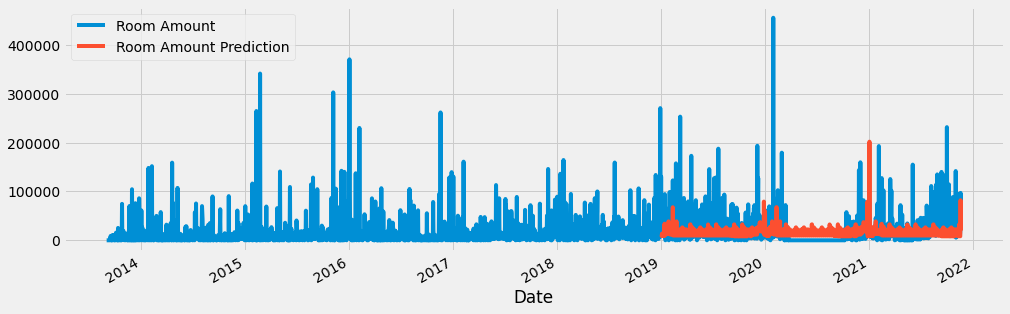

In [11]:
Data_Room_all[['Room Amount', 'Room Amount Prediction']].plot(figsize=(15, 5))


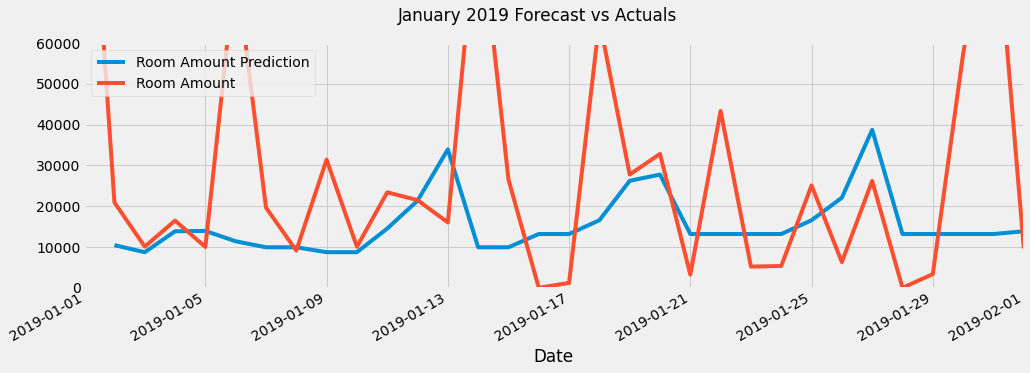

In [12]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
Data_Room_all[['Room Amount Prediction', 'Room Amount']].plot(ax=ax,
                                                style=['-', '-'])
ax.set_xbound(lower='01-01-2019', upper='02-01-2019')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2019 Forecast vs Actuals')


In [13]:
mean_squared_error(y_true=Data_Room_Test['Room Amount'],
                   y_pred=Data_Room_Test['Room Amount Prediction'])


1144211328.1002512

In [14]:
mean_absolute_error(y_true=Data_Room_Test['Room Amount'],
                    y_pred=Data_Room_Test['Room Amount Prediction'])


18756.359000326447

In [15]:
Data_Room_Test['error'] = Data_Room_Test['Room Amount'] - Data_Room_Test['Room Amount Prediction']
Data_Room_Test['abs_error'] = Data_Room_Test['error'].apply(np.abs)
error_by_day = Data_Room_Test.groupby(['year', 'month', 'dayofmonth']) \
    .mean()[['Room Amount', 'Room Amount Prediction', 'error', 'abs_error']]


In [16]:
error_by_day.sort_values('error', ascending=True).head(10)


Room Amount  Room Amount Prediction          error  \
year month dayofmonth                                                       
2021 1     2               17695.0           201712.875000 -184017.875000   
2019 12    28               5292.0            79165.664062  -73873.664062   
2020 12    26              27269.0            79165.664062  -51896.664062   
           31              22791.0            74051.187500  -51260.187500   
     1     1               10846.0            59834.164062  -48988.164062   
     2     11              22231.0            67629.062500  -45398.062500   
           23               2184.0            38719.351562  -36535.351562   
     11    15                  0.0            32631.578125  -32631.578125   
     9     13                  0.0            32631.578125  -32631.578125   
     6     14                  0.0            32631.578125  -32631.578125   

                           abs_error  
year month dayofmonth                 
2021 1     2           184017.875000  
2019 12    28           73873.664062  
2020 12    26           51896.664062  
           31           51260.187500  
     1     1            48988.164062  
     2     11           45398.062500  
           23           36535.351562  
     11    15           32631.578125  
     9     13           32631.578125  
     6     14           32631.578125

In [17]:
error_by_day.sort_values('abs_error', ascending=False).head(10)


Room Amount  Room Amount Prediction          error  \
year month dayofmonth                                                       
2020 1     30             455154.0            13179.624023  441974.375977   
2019 3     9              252882.0            22624.800781  230257.199219   
2021 10    1              231400.0            12059.771484  219340.228516   
     1     2               17695.0           201712.875000 -184017.875000   
     2     4              192698.0            13179.624023  179518.375977   
2019 12    5              193309.0            15740.885742  177568.114258   
     4     17             172792.0             9868.163086  162923.836914   
     7     21             187367.0            26456.554688  160910.445312   
2020 2     29             179199.0            22089.753906  157109.246094   
     12    1              159540.0            11734.122070  147805.877930   

                           abs_error  
year month dayofmonth                 
2020 1     30          441974.375977  
2019 3     9           230257.199219  
2021 10    1           219340.228516  
     1     2           184017.875000  
     2     4           179518.375977  
2019 12    5           177568.114258  
     4     17          162923.836914  
     7     21          160910.445312  
2020 2     29          157109.246094  
     12    1           147805.877930

In [18]:
error_by_day.sort_values('abs_error', ascending=True).head(10)


Room Amount  Room Amount Prediction       error  \
year month dayofmonth                                                    
2019 8     3               17991.0            18072.384766  -81.384766   
2021 10    26               8241.0             8135.740234  105.259766   
2019 6     8               22515.0            22624.800781 -109.800781   
2021 1     6                8839.0             8727.440430  111.559570   
     6     11              14071.0            13958.237305  112.762695   
2019 1     12              21491.0            21349.582031  141.417969   
2021 10    23              21896.0            22089.753906 -193.753906   
2020 1     3               14051.0            13855.230469  195.769531   
2019 3     19              10068.0             9868.163086  199.836914   
2020 11    23              11518.0            11734.122070 -216.122070   

                        abs_error  
year month dayofmonth              
2019 8     3            81.384766  
2021 10    26          105.259766  
2019 6     8           109.800781  
2021 1     6           111.559570  
     6     11          112.762695  
2019 1     12          141.417969  
2021 10    23          193.753906  
2020 1     3           195.769531  
2019 3     19          199.836914  
2020 11    23          216.122070